In [117]:
# If you would like to install packages that are not installed by default, you may do so here.
# For example:

# import sys
# !{sys.executable} -m pip install package1 package2

In [118]:
# Import libraries
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

##### Read and clean the data.

In [119]:
# Read dataset

df = pd.read_csv("listing_cars.csv")
df = df.rename(columns={'Unnamed: 0': 'id_cars'})
df

# Shuffle the dataframe and set the random_state for reproducibility.
df = df.sample(frac=1, random_state=111)

cars = df.copy(deep=True)
cars

,id_cars,name,status,lastupdated,exactmodel,cartype,enginesize,transmission,seats,previousowners,bodyinteriorcolour,registrationexpiry,lastserviced,usd_price,brand,model,km_mileage
20235,20235,2020 Lexus ES250,Active,2020-05-22,ES250,Sedan,2487.0,Automatic,5.0,0.0,Gold / Beige,NaN,NaN,59618,Lexus,Lexus ES250,600.0
32175,32175,2010 Bentley Flying Spur,Active,2020-02-12,NaN,Luxury,5998.0,Automatic,5.0,1.0,Black / Grey,11,NaN,50701,Bentley,Bentley Flying Spur,51000.0
10678,10678,2007 Mercedes-Benz B200,Sold,2018-07-22,MB B200 Turbo (T245),Hatchback,2035.0,Automatic,5.0,1.0,Grey / Black,8 / 2018,7 / 2018,8280,Mercedes,Mercedes,44000.0
25173,25173,2018 Audi Q7,Active,2020-11-09,Q7 40 TFSI Quattro,SUV/Crossover,1984.0,Automatic,7.0,0.0,Black / Bronze,NaN,NaN,68535,Audi,Audi Q7,23000.0
29710,29710,2011 Ferrari F458,Active,2020-03-08,458 Italia,Coupe,4497.0,Automatic,2.0,2.0,Yellow / Black,NaN,NaN,226752,Ferrari,Ferrari F458,24000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,7490,2013 Lamborghini Gallardo,Sold,2019-03-10,LP560-4 FL II 50 Anniversary,Coupe,5204.0,Automatic,2.0,0.0,Black / Black,NaN,NaN,226752,Lamborghini,Lamborghini Gallardo,13000.0
25257,25257,2017 Mercedes-Benz CLA250,Sold,2020-07-24,CLA250 AMG FACELIFT,Sedan,1991.0,Automatic,5.0,0.0,Grey / Black,8 / 2020,NaN,40510,Mercedes,Mercedes,20000.0
4820,4820,2011 Honda CR-Z,Sold,2017-05-22,NaN,Hatchback,1500.0,Automatic,5.0,NaN,White / Black,NaN,NaN,16306,Honda,Honda CR,1.0
10196,10196,2011 Mercedes-Benz E250,Sold,2018-03-11,E250 Cabrio,Convertible,NaN,Automatic,4.0,0.0,Black / Black,NaN,NaN,27771,Mercedes,Mercedes,28000.0


In [120]:
# Le's first analyze the data. One can easily see that engine size assume the minimum value 1. 
# Moreover, the minimum price is USD 1. The rows corresponding to these values will be dropped.
cars.describe()

,id_cars,enginesize,seats,previousowners,usd_price,km_mileage
count,33016.00000,29562.000000,30713.000000,29725.000000,3.301600e+04,3.171800e+04
mean,16507.50000,2987.062253,4.816104,1.207065,5.369508e+04,7.556116e+05
std,9531.04258,4034.008466,1.462381,1.653391,2.132047e+05,3.752809e+07
min,0.00000,1.000000,1.000000,0.000000,0.000000e+00,1.000000e+00
25%,8253.75000,1994.250000,4.000000,0.000000,1.261100e+04,2.200000e+04
50%,16507.50000,2500.000000,5.000000,1.000000,2.723700e+04,4.400000e+04
75%,24761.25000,3596.000000,5.000000,2.000000,5.961800e+04,7.000000e+04
max,33015.00000,520000.000000,9.000000,12.000000,2.547771e+07,2.147484e+09


In [121]:
# Discarding rows for 'enginesize' = 1, and 'usd_price'=0.
cars = cars[cars.usd_price > 0]
cars = cars[cars.enginesize > 1]
cars

,id_cars,name,status,lastupdated,exactmodel,cartype,enginesize,transmission,seats,previousowners,bodyinteriorcolour,registrationexpiry,lastserviced,usd_price,brand,model,km_mileage
20235,20235,2020 Lexus ES250,Active,2020-05-22,ES250,Sedan,2487.0,Automatic,5.0,0.0,Gold / Beige,NaN,NaN,59618,Lexus,Lexus ES250,600.0
32175,32175,2010 Bentley Flying Spur,Active,2020-02-12,NaN,Luxury,5998.0,Automatic,5.0,1.0,Black / Grey,11,NaN,50701,Bentley,Bentley Flying Spur,51000.0
10678,10678,2007 Mercedes-Benz B200,Sold,2018-07-22,MB B200 Turbo (T245),Hatchback,2035.0,Automatic,5.0,1.0,Grey / Black,8 / 2018,7 / 2018,8280,Mercedes,Mercedes,44000.0
25173,25173,2018 Audi Q7,Active,2020-11-09,Q7 40 TFSI Quattro,SUV/Crossover,1984.0,Automatic,7.0,0.0,Black / Bronze,NaN,NaN,68535,Audi,Audi Q7,23000.0
29710,29710,2011 Ferrari F458,Active,2020-03-08,458 Italia,Coupe,4497.0,Automatic,2.0,2.0,Yellow / Black,NaN,NaN,226752,Ferrari,Ferrari F458,24000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9145,9145,2012 Toyota 86,Sold,2018-03-18,NaN,Coupe,2000.0,Manual,3.0,2.0,Grey / Black,NaN,NaN,23949,Toyota,Toyota 86,33000.0
28790,28790,2015 Landrover Discovery,Active,2020-06-30,NaN,SUV/Crossover,2000.0,Automatic,7.0,0.0,Green / Grey,NaN,NaN,40510,Landrover,Landrover Discovery,49000.0
7490,7490,2013 Lamborghini Gallardo,Sold,2019-03-10,LP560-4 FL II 50 Anniversary,Coupe,5204.0,Automatic,2.0,0.0,Black / Black,NaN,NaN,226752,Lamborghini,Lamborghini Gallardo,13000.0
25257,25257,2017 Mercedes-Benz CLA250,Sold,2020-07-24,CLA250 AMG FACELIFT,Sedan,1991.0,Automatic,5.0,0.0,Grey / Black,8 / 2020,NaN,40510,Mercedes,Mercedes,20000.0


In [122]:
# Check the counts of NaNs in the data. Those columns with a large number of NaNs will be discarded
# also considering the importance of the data for the posterior analyses. 

nans_df = cars.isna().sum().rename_axis('Columns').reset_index(name='Counts')
nans_df["NaNportions"] = nans_df["Counts"] / cars.shape[0]

nans_df

,Columns,Counts,NaNportions
0,id_cars,0,0.000000
1,name,0,0.000000
2,status,0,0.000000
3,lastupdated,0,0.000000
4,exactmodel,6236,0.211154
5,cartype,878,0.029729
6,enginesize,0,0.000000
7,transmission,3,0.000102
8,seats,433,0.014662
9,previousowners,2446,0.082823


In [123]:
# One can observe that 'lastserviced' and 'registrationexpiry' have a large number of NaNs; moreover, 
# these informations are not so relevant for the car pricing. Therefore, thy can be discarded. 
# 
# Further, 'exactmodel' is not important since the car's characteristics are used for pricing. 
# On the other hand, 'name' can be used for determining the model's year.

# New column for the model's year retrieved from 'name'.
cars["model_year"] = cars["name"].astype(str).str[0:5]
cars["model_year"] = cars["model_year"].astype(int)

# Eliminate rows with NaNs for 'cartype', 'enginesize', 'transmission', 'seats', 'previousowners', 
# and 'km_mileage'

cars.dropna(subset = ["cartype"], inplace=True)
cars.dropna(subset = ["enginesize"], inplace=True)
cars.dropna(subset = ["transmission"], inplace=True)
cars.dropna(subset = ["seats"], inplace=True)
cars.dropna(subset = ["previousowners"], inplace=True)
cars.dropna(subset = ["km_mileage"], inplace=True)

cars = cars.drop(columns=["name", "exactmodel", "registrationexpiry", "lastserviced"])

cars

,id_cars,status,lastupdated,cartype,enginesize,transmission,seats,previousowners,bodyinteriorcolour,usd_price,brand,model,km_mileage,model_year
20235,20235,Active,2020-05-22,Sedan,2487.0,Automatic,5.0,0.0,Gold / Beige,59618,Lexus,Lexus ES250,600.0,2020
32175,32175,Active,2020-02-12,Luxury,5998.0,Automatic,5.0,1.0,Black / Grey,50701,Bentley,Bentley Flying Spur,51000.0,2010
10678,10678,Sold,2018-07-22,Hatchback,2035.0,Automatic,5.0,1.0,Grey / Black,8280,Mercedes,Mercedes,44000.0,2007
25173,25173,Active,2020-11-09,SUV/Crossover,1984.0,Automatic,7.0,0.0,Black / Bronze,68535,Audi,Audi Q7,23000.0,2018
29710,29710,Active,2020-03-08,Coupe,4497.0,Automatic,2.0,2.0,Yellow / Black,226752,Ferrari,Ferrari F458,24000.0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530,11530,Sold,2018-06-10,Sedan,1984.0,Automatic,5.0,0.0,Grey / Black,16306,Audi,Audi A6,170000.0,2013
9145,9145,Sold,2018-03-18,Coupe,2000.0,Manual,3.0,2.0,Grey / Black,23949,Toyota,Toyota 86,33000.0,2012
28790,28790,Active,2020-06-30,SUV/Crossover,2000.0,Automatic,7.0,0.0,Green / Grey,40510,Landrover,Landrover Discovery,49000.0,2015
7490,7490,Sold,2019-03-10,Coupe,5204.0,Automatic,2.0,0.0,Black / Black,226752,Lamborghini,Lamborghini Gallardo,13000.0,2013


In [124]:
# The strategy adopted here is based on a regression scheme to determine the difference between the 
# price of a car with given features predicted from the information of sold cars in the period 2019/2020.
# This period (2019/2020) is chosen because the cars active in the plataform were updated in 2019/2020. 
# Moreover, one can consider the fact that the price depreciation of cars sold before 2019 could add
# bias in the prediction for the period 2019/2020. 
# 
# Next, one can chnage the categorical data into numerical labels.

# Change categorical data to numerical identifiers.
cars.brand = pd.Categorical(cars.brand)
cars["brand_label"] = cars.brand.cat.codes

# For decoding the labels.
brand = pd.Categorical(cars.brand).categories

cars.model = pd.Categorical(cars.model)
cars["model_label"] = cars.model.cat.codes

# For decoding the labels.
model = pd.Categorical(cars.model).categories

cars.cartype = pd.Categorical(cars.cartype)
cars["cartype_label"] = cars.cartype.cat.codes

# For decoding the labels.
cartype = pd.Categorical(cars.cartype).categories

cars.transmission = pd.Categorical(cars.transmission)
cars["transmission_label"] = cars.transmission.cat.codes

# For decoding the labels.
transmission = pd.Categorical(cars.transmission).categories

cars.bodyinteriorcolour = pd.Categorical(cars.bodyinteriorcolour)
cars["bodyinteriorcolour_label"] = cars.bodyinteriorcolour.cat.codes

# For decoding the labels.
bodyinteriorcolour = pd.Categorical(cars.bodyinteriorcolour).categories

cars.status = pd.Categorical(cars.status)
cars["status_label"] = cars.status.cat.codes

# For decoding the labels.
status = pd.Categorical(cars.status).categories

# Get the year the car's status was updated in the platform.
cars["yearupdate"] = pd.DatetimeIndex(cars["lastupdated"]).year
cars

,id_cars,status,lastupdated,cartype,enginesize,transmission,seats,previousowners,bodyinteriorcolour,usd_price,...,model,km_mileage,model_year,brand_label,model_label,cartype_label,transmission_label,bodyinteriorcolour_label,status_label,yearupdate
20235,20235,Active,2020-05-22,Sedan,2487.0,Automatic,5.0,0.0,Gold / Beige,59618,...,Lexus ES250,600.0,2020,41,339,8,0,94,0,2020
32175,32175,Active,2020-02-12,Luxury,5998.0,Automatic,5.0,1.0,Black / Grey,50701,...,Bentley Flying Spur,51000.0,2010,9,151,5,0,19,0,2020
10678,10678,Sold,2018-07-22,Hatchback,2035.0,Automatic,5.0,1.0,Grey / Black,8280,...,Mercedes,44000.0,2007,49,421,3,0,119,1,2018
25173,25173,Active,2020-11-09,SUV/Crossover,1984.0,Automatic,7.0,0.0,Black / Bronze,68535,...,Audi Q7,23000.0,2018,6,45,7,0,13,0,2020
29710,29710,Active,2020-03-08,Coupe,4497.0,Automatic,2.0,2.0,Yellow / Black,226752,...,Ferrari F458,24000.0,2011,19,197,2,0,244,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530,11530,Sold,2018-06-10,Sedan,1984.0,Automatic,5.0,0.0,Grey / Black,16306,...,Audi A6,170000.0,2013,6,39,8,0,119,1,2018
9145,9145,Sold,2018-03-18,Coupe,2000.0,Manual,3.0,2.0,Grey / Black,23949,...,Toyota 86,33000.0,2012,71,587,2,1,119,1,2018
28790,28790,Active,2020-06-30,SUV/Crossover,2000.0,Automatic,7.0,0.0,Green / Grey,40510,...,Landrover Discovery,49000.0,2015,40,322,7,0,110,0,2020
7490,7490,Sold,2019-03-10,Coupe,5204.0,Automatic,2.0,0.0,Black / Black,226752,...,Lamborghini Gallardo,13000.0,2013,39,315,2,0,11,1,2019


In [125]:
# Create a data frame only with the numerical values.

variables = ["id_cars", "enginesize", "seats", "previousowners", "km_mileage", "model_year", "brand_label", 
      "cartype_label", "transmission_label", "bodyinteriorcolour_label", "yearupdate", "usd_price", "status_label"]

cars_num = cars[variables]

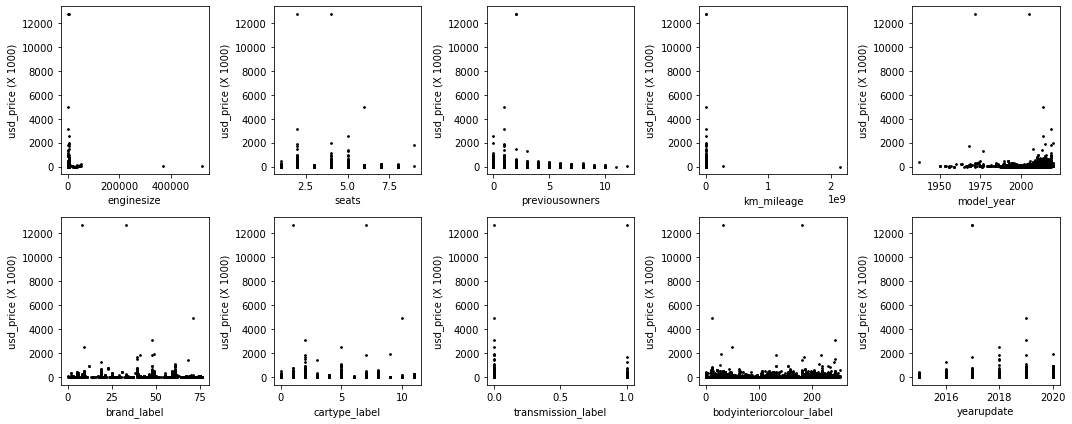

In [126]:
# Visualize the data from original data frame without NaNs. In this case (y=f(X)) and
# usd_price = f(enginesize,seats,previousowners,km_mileage,model_year, brand_label,cartype_label,
#               transmission_label, bodyinteriorcolour_label,yearupdate)

variables_plot = ["enginesize", "seats", "previousowners", "km_mileage", "model_year", "brand_label", 
      "cartype_label", "transmission_label", "bodyinteriorcolour_label", "yearupdate"]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

c = 0
for i in range(2):
    for j in range(5):

        axs[i, j].scatter(cars_num[variables_plot[c]], cars_num["usd_price"] / 1000, s=3, c='k')
        #axs[i, j].set_title('Axis [0, 0]')
        axs[i, j].set_xlabel(variables_plot[c])
        axs[i, j].set_ylabel('usd_price (X 1000)')
        c+=1

fig.tight_layout()
plt.show()

In [127]:
# Next, we eliminate rows in the Data Frame containing outliers for improved regression. 
# To this aim, we can use the Z score to determine how far some numbers are from the mean.
# In this case, a point is an outlier if it is at 3 sigmas from the mean.

# Removing outliers from enginesize, km_mileage, and usd_price.
outl = ["enginesize", "km_mileage", "usd_price"]
cars_num = cars_num[(np.abs(stats.zscore(cars_num[outl])) < 3).all(axis=1)]

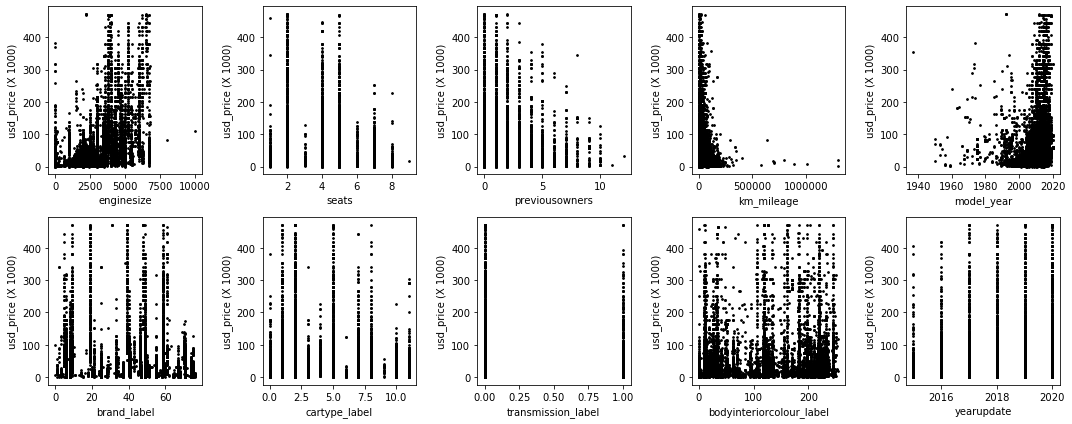

In [128]:
# Visualize the date with outliers removed.

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

c = 0
for i in range(2):
    for j in range(5):

        axs[i, j].scatter(cars_num[variables_plot[c]], cars_num["usd_price"] / 1000, s=3, c='k')
        #axs[i, j].set_title('Axis [0, 0]')
        axs[i, j].set_xlabel(variables_plot[c])
        axs[i, j].set_ylabel('usd_price (X 1000)')
        c+=1

fig.tight_layout()
plt.show()

##### Split the data.

In [129]:
# Let's create two data frames, for both active and sold cars.
cars_active = cars_num[cars_num.status_label == 0]
cars_sold = cars_num[cars_num.status_label == 1]

In [130]:
cars_active.head()

,id_cars,enginesize,seats,previousowners,km_mileage,model_year,brand_label,cartype_label,transmission_label,bodyinteriorcolour_label,yearupdate,usd_price,status_label
20235,20235,2487.0,5.0,0.0,600.0,2020,41,8,0,94,2020,59618,0
32175,32175,5998.0,5.0,1.0,51000.0,2010,9,5,0,19,2020,50701,0
25173,25173,1984.0,7.0,0.0,23000.0,2018,6,7,0,13,2020,68535,0
29710,29710,4497.0,2.0,2.0,24000.0,2011,19,2,0,244,2020,226752,0
17247,17247,3456.0,5.0,0.0,12000.0,2017,41,4,0,221,2020,76178,0


In [131]:
cars_sold.head()

,id_cars,enginesize,seats,previousowners,km_mileage,model_year,brand_label,cartype_label,transmission_label,bodyinteriorcolour_label,yearupdate,usd_price,status_label
10678,10678,2035.0,5.0,1.0,44000.0,2007,49,3,0,119,2018,8280,1
5903,5903,2497.0,5.0,0.0,18700.0,2011,8,8,0,11,2017,19108,1
7341,7341,1798.0,5.0,0.0,29200.0,2012,74,8,0,216,2017,10064,1
158,158,3200.0,4.0,2.0,44000.0,2007,74,3,0,119,2015,15287,1
17465,17465,1999.0,5.0,2.0,66000.0,2014,40,7,0,192,2020,46879,1


In [132]:
# Get the data frame of cars sold between 2019 and 2020, to be compatible with the time interval of 
# available cars according to the platform.

# Show the number of Cars active: updated in the platform between 2019 and 2020.
print(min(cars_active["yearupdate"]), max(cars_active["yearupdate"]), len(cars_active["yearupdate"]))

# Show the number of Cars sold in 2019/2020: updated in the platform between 2015 and 2020.
print(min(cars_sold["yearupdate"]), max(cars_sold["yearupdate"]), len(cars_sold[cars_sold.yearupdate > 2018]))

# Data frame for cars sold in 2019/2020.
cars_sold_last = cars_sold[cars_sold.yearupdate > 2018]
print(min(cars_sold_last["yearupdate"]), max(cars_sold_last["yearupdate"]), len(cars_sold_last))

cars_sold_last

2019 2020 13888
2015 2020 3315
2019 2020 3315


,id_cars,enginesize,seats,previousowners,km_mileage,model_year,brand_label,cartype_label,transmission_label,bodyinteriorcolour_label,yearupdate,usd_price,status_label
17465,17465,1999.0,5.0,2.0,66000.0,2014,40,7,0,192,2020,46879,1
25240,25240,1999.0,7.0,1.0,36000.0,2016,40,7,0,51,2020,46879,1
17002,17002,1997.0,5.0,0.0,54000.0,2014,8,8,0,119,2020,25223,1
16232,16232,3600.0,4.0,2.0,63000.0,2007,59,2,0,11,2020,89172,1
12789,12789,3500.0,5.0,1.0,38000.0,2013,49,5,0,197,2019,31592,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22872,22872,2521.0,7.0,0.0,110000.0,2011,75,7,0,10,2020,9172,1
30661,30661,3500.0,7.0,2.0,91000.0,2013,71,2,0,197,2020,17580,1
10658,10658,1997.0,4.0,0.0,47000.0,2014,8,1,0,126,2020,37962,1
7490,7490,5204.0,2.0,0.0,13000.0,2013,39,2,0,11,2019,226752,1


#### Prepare the data for regression.

In [133]:
# Prepare datasets for regression of a model y = f(X):
# usd_price = f(enginesize,seats,previousowners,km_mileage,model_year, brand_label,cartype_label,
#               transmission_label, bodyinteriorcolour_label,yearupdate)

variables = ["enginesize", "seats", "previousowners", "km_mileage", "model_year", "brand_label", 
      "cartype_label", "transmission_label", "bodyinteriorcolour_label", "yearupdate"]

# The training set is composed by the data of sold cars in 2019/2020, because I would like to predict if the
# active cars have a price consistent with the history of sold cars.
X_train_df = cars_sold_last[variables]
y_train_df = cars_sold_last[["usd_price"]]

X_test_df = cars_active[variables]
y_test_df = cars_active[["usd_price"]]

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()[:, 0]
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()[:, 0]

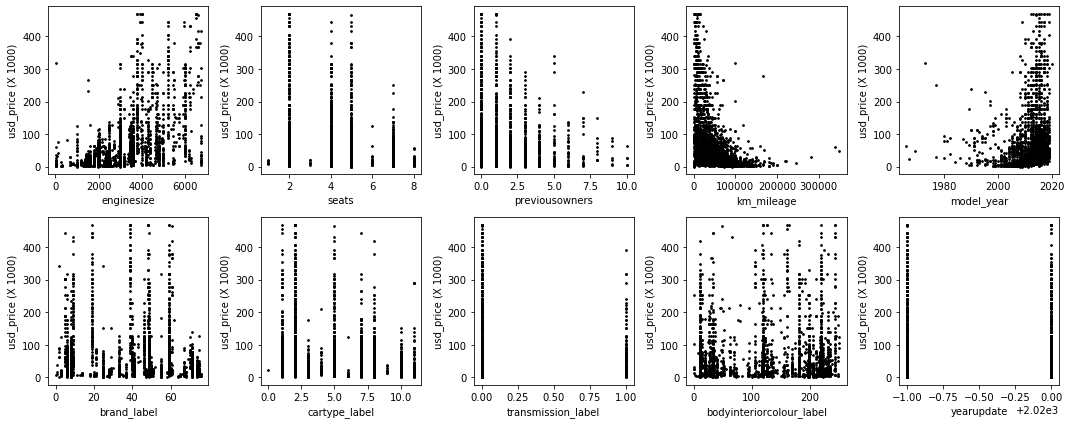

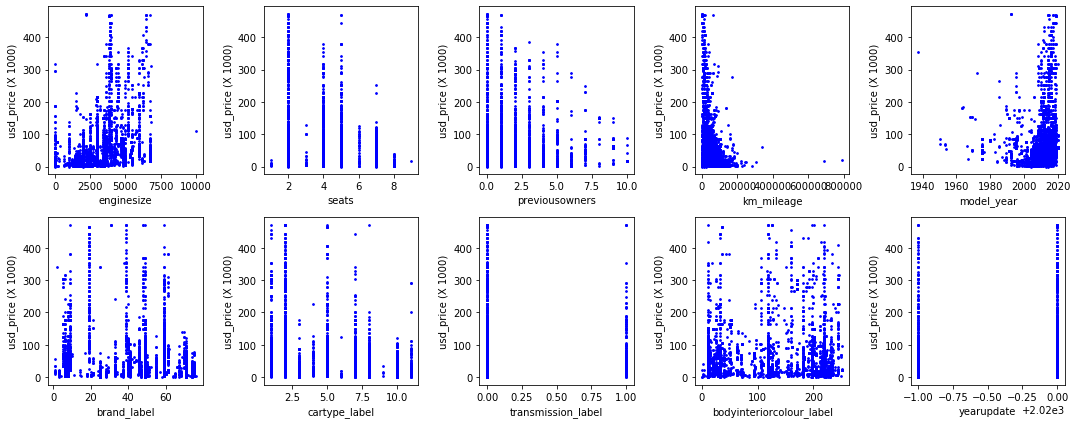

In [134]:
# Visualize the data in both the training (black) and test (blue) sets.

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

c = 0
for i in range(2):
    for j in range(5):

        axs[i, j].scatter(X_train[:,c], y_train / 1000, s=3, c='k')
        #axs[i, j].set_title('Axis [0, 0]')
        axs[i, j].set_xlabel(variables[c])
        axs[i, j].set_ylabel('usd_price (X 1000)')
        c+=1

fig.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

c = 0
for i in range(2):
    for j in range(5):

        axs[i, j].scatter(X_test[:,c], y_test / 1000, s=3, c='b')
        #axs[i, j].set_title('Axis [0, 0]')
        axs[i, j].set_xlabel(variables[c])
        axs[i, j].set_ylabel('usd_price (X 1000)')
        c+=1

fig.tight_layout()
plt.show()

#### Tranining, validation, and testing.

For the validation three models are selected:
* Random Forest
* Histogram-based Gradient Boosting (HGBR)
* Gaussian Process

The goal is to veryfy which one perform better, and from the results one can easily see that the Random Forest and the Histogram-based Boosting Regressor perform better than the Gaussian Process. In this problem, the (HBGR) is selected.

In [135]:
models = []

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(lscale, length_scale_bounds="fixed")
models.append(("RF",RandomForestRegressor(max_depth=30, random_state=0)))
models.append(("HGBR",HistGradientBoostingRegressor()))
models.append(("GPR",GaussianProcessRegressor(kernel=kernel, random_state=0,normalize_y=True)))

# Perform the cross-validation with kfold, and estimate the scores of each fold..
for name,model in models:
    kfold = KFold(n_splits=3, random_state=None)
    cv_result = cross_val_score(model,X_train, y_train, cv = kfold)
    print(name, cv_result)

RF [0.80097739 0.7952428  0.81661314]
HGBR [0.83681871 0.8282634  0.84428481]
GPR [0.21923892 0.10435011 0.22744554]


#### Training

The strategy to verify the good oportunities consists in using the data of sold cars to predict the price of a car based on its characteristics to see if they are currently overpriced or not. We can do this by using the regressor to predict the proce of the car.

In [136]:
est = HistGradientBoostingRegressor().fit(X_train, y_train)
tscore_est = est.score(X_train, y_train)
print("Train score: "+str(tscore_est))

y_pred_est = est.predict(X_test)
rscore_est = r2_score(y_test, y_pred_est)

print("Test r2 score: "+str(rscore_est))

Train score: 0.9534868487325421
Test r2 score: 0.8107223731091437


In [137]:
# Get the identifies and names of the cars active in the platform

id_cars_active = cars_active["id_cars"].to_numpy()
name_cars = df["name"].to_numpy() 

In [138]:
# Predict the values of the cars active in the platform using the GPR trained on the consolidated data (sold cars).

predicted_price = []
current_price = []
difference = []
good_opportunity = []
name = []
for idx in range(len(y_test)):

    # Discard the decimals in the predicted outcome.
    
    # Predicted.
    pred = int(gpr.predict(X_test[idx].reshape(1, -1))[0])
    
    # Current price of the car.
    current = int(y_test[idx])
    predicted_price.append(pred)
    current_price.append(current)
    
    # Get the name of the car.
    name.append(name_cars[id_cars_active[idx]])

    # Compute the difference between the current and predicted prices.
    delta = current - pred
    difference.append(delta)
    
    # Based on the predicted and current price, determine if this is a good deal.
    # This is a hard threshold. One could be more flexible here.
    if delta <= 0:
        good_opportunity.append('yes')
    else:
        good_opportunity.append('no')


In [139]:
# Create a data frame for the deals.
evaluation = {'name': name, 'current_price': current_price, 'predicted_price': predicted_price, 
              'difference': difference, 'good_opportunity': good_opportunity}

evaluation_df = pd.DataFrame(data=evaluation)
evaluation_df

,name,current_price,predicted_price,difference,good_opportunity
0,2010 Honda Stream,59618,75958,-16340,yes
1,2016 Landrover Discovery,50701,85385,-34684,yes
2,1976 Rolls Royce Corniche,68535,23091,45444,no
3,2009 Porsche Cayman S,226752,226751,1,no
4,2013 BMW X1,76178,68535,7643,no
...,...,...,...,...,...
13883,2012 Mercedes-Benz S500,127134,58226,68908,no
13884,2010 BMW 323i,40510,14734,25776,no
13885,1975 Rolls Royce Silver Shadow,5070,5070,0,yes
13886,2005 Mercedes-Benz CLS500,43057,40509,2548,no


In [140]:
# Create a dataframe for the positive evaluations.
good_evaluation = evaluation_df[evaluation_df.good_opportunity == "yes"].sort_values(by=["difference"], ascending=True)
good_evaluation

,name,current_price,predicted_price,difference,good_opportunity
6530,2013 Porsche Panamera S,94013,589690,-495677,yes
5087,2007 BMW 323i,94013,589690,-495677,yes
9439,2015 Porsche GT3 RS,13758,412624,-398866,yes
288,2013 BMW 520i,21401,342668,-321267,yes
4916,2010 Audi A5,21401,342668,-321267,yes
...,...,...,...,...,...
6907,2012 Infiniti QX70,7006,7006,0,yes
6936,2014 Mercedes-Benz A45,18854,18854,0,yes
6949,2018 Mercedes-Benz S500,44331,44331,0,yes
6836,2015 Mercedes-Benz C200,16306,16306,0,yes


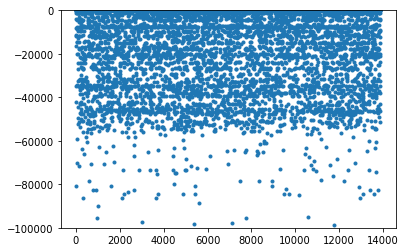

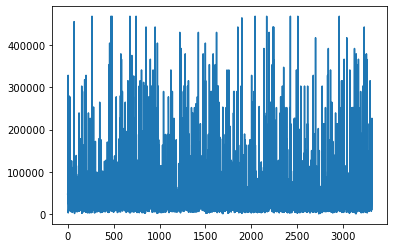

In [153]:
plt.plot(good_evaluation["difference"],'.')
plt.ylim([-100000,0])
plt.show()

plt.plot(y_train)

##### Building a weekly plot to assess the state of household personal finances.

The solution of this problem is based on the offer vs demand analysis. In this regard, one can assume that the households income is proportional to the volume of sold and available cars every week. Next, a graphic of the cars sold weekly from 2015 to 2020 is presented.

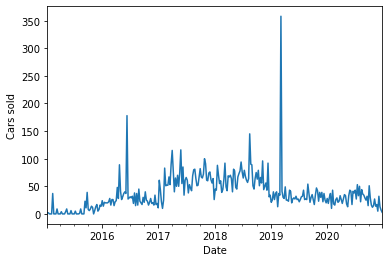

In [141]:
# Ensure the 'lastupdated' column is datetime. 
cars['lastupdated'] = pd.to_datetime(cars['lastupdated'])

# Get the rows corresponding to sold cars.
sold_cars = cars[cars.status_label == 1].copy(deep=True)

# Get the rows corresponding to active cars and set 'status_label' to 1 because we need to sum them every week.
active_cars = cars[cars.status_label == 0].copy(deep=True)
active_cars["status_label"] = 1

# Group the data weekly.
cars_sold_weekly = sold_cars.resample('W', on='lastupdated').status_label.sum()
cars_active_weekly = active_cars.resample('W', on='lastupdated').status_label.sum()

# Plot 

cars_sold_weekly.plot()
plt.xlabel('Date')
plt.ylabel('Cars sold')
plt.show()


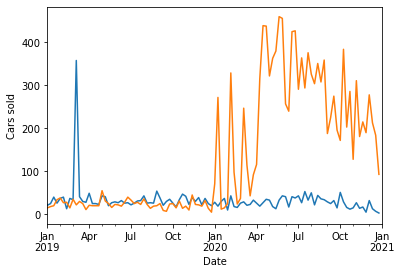

In [142]:
# However, I should compare both the cars sold and still available in the period 2019/2020,
# Because the available cars were updated in the platform in 2019/2020.

ax=cars_sold_weekly.plot()
cars_active_weekly.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Cars sold')
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-12-31'))
plt.show()

#plt.plot(cars_active_weekly)

Based on the graphic above, one can see that the amount of cars being sold does not change very much, only some high frequency fluctuations are observed. On the other hand, a big jump in the amount of available cars are observed after Janury 2020, a jump that can be associated with the Covid-19 pandemics with consequent increase in the unemplyment rate (see the USA unemployment data: https://tradingeconomics.com/united-states/unemployment-rate). 
